## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from transformers import AutoTokenizer, TFXLMRobertaModel, TFXLMRobertaForTokenClassification

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_URL = "PlanTL-GOB-ES/pharmaconer"
MODEL_NAME = "xlm-roberta-base"

BATCH_SIZE = 64

## The Dataset

In [4]:
dataset = load_dataset(DATASET_URL)
TAGS = dataset["train"].features["ner_tags"].feature

print(TAGS)

ClassLabel(names=['O', 'B-NO_NORMALIZABLES', 'B-NORMALIZABLES', 'B-PROTEINAS', 'B-UNCLEAR', 'I-NO_NORMALIZABLES', 'I-NORMALIZABLES', 'I-PROTEINAS', 'I-UNCLEAR'], id=None)


In [5]:
def get_examples_per_tag(dataset):
    list_tags = [tag for tags in dataset["ner_tags"] for tag in tags]
    tags = pd.Series(list_tags).value_counts()
    return list(tags)

[Text(0, 0, '8129'), Text(0, 0, '3787'), Text(0, 0, '3952')]

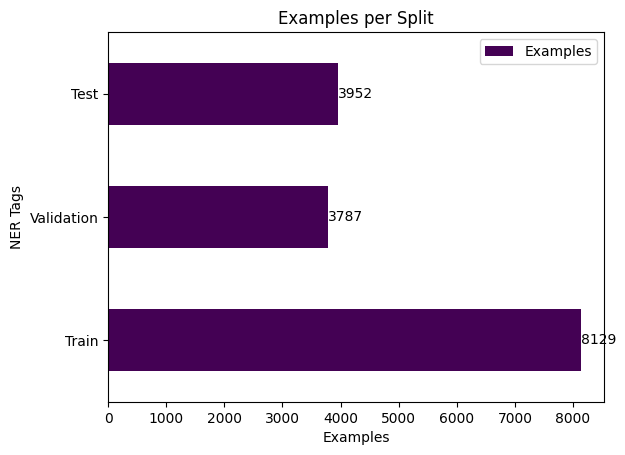

In [6]:
examples_per_split = {
    "Train": dataset["train"].num_rows,
    "Validation": dataset["validation"].num_rows,
    "Test": dataset["test"].num_rows,
}

ax = pd.DataFrame(examples_per_split, index=["Examples"]).T.plot.barh(
    title="Examples per Split", xlabel="Examples", ylabel="NER Tags", colormap="viridis"
)
ax.bar_label(ax.containers[-1])

Let's see how many tags we have per class:

[Text(0, 0, '4347'),
 Text(0, 0, '2963'),
 Text(0, 0, '1120'),
 Text(0, 0, '634'),
 Text(0, 0, '166'),
 Text(0, 0, '50'),
 Text(0, 0, '25'),
 Text(0, 0, '7')]

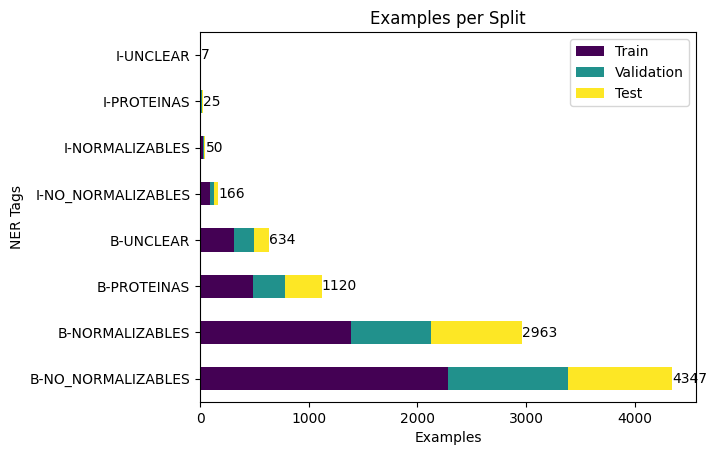

In [7]:
tags_per_class = {
    "Train": get_examples_per_tag(dataset["train"])[1:],
    "Validation": get_examples_per_tag(dataset["validation"])[1:],
    "Test": get_examples_per_tag(dataset["test"])[1:],
}

ax = pd.DataFrame(tags_per_class, index=TAGS.names[1:]).plot.barh(
    title="Examples per Split",
    xlabel="Examples",
    ylabel="NER Tags",
    stacked=True,
    colormap="viridis",
)
ax.bar_label(ax.containers[-1])

- The tags are disbalanced, and using accuracy may not be suitable. F1-Score, Recall and Precision will be more suitable 

In [8]:
list_tags = [tag for tags in dataset["train"]["ner_tags"] for tag in tags]
tags = pd.Series(list_tags).value_counts()
list(tags)

[198569, 2282, 1392, 486, 314, 88, 24, 13, 3]

In [9]:
tokens_length = [len(tokens) for tokens in dataset["train"]["tokens"]]

len_sequnces = {
    "Train": [len(tokens) for tokens in dataset["train"]["tokens"]],
    "Validation": [len(tokens) for tokens in dataset["validation"]["tokens"]],
    "Test": [len(tokens) for tokens in dataset["test"]["tokens"]],
}

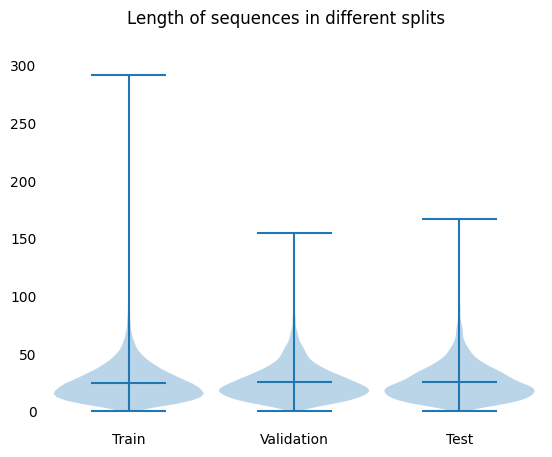

In [10]:

fig, ax = plt.subplots(1, 3, sharey=True)
fig.suptitle("Length of sequences in different splits")

for idx, split in enumerate(["Train", "Validation", "Test"]):
    ax[idx].violinplot(len_sequnces[split], showmeans=True)
    ax[idx].set_xlabel(split)
    for key, spine in ax[idx].spines.items():
        spine.set_visible(False) 
    ax[idx].tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False)

plt.subplots_adjust(wspace=0)
plt.show()

Let's see how many examples are above the  200 tokens:

In [11]:
print(
    f"These are the lengths of the 10 longest sequences:\n\t{sorted(len_sequnces['Train'])[-10:]}"
)

These are the lengths of the 10 longest sequences:
	[124, 128, 129, 132, 135, 139, 147, 162, 184, 292]


We can see that only 1 is above 200, and probabably droping it would not make a huge difference. We will determine that in the future, depending on the model we select.

Now, let's see an example of how the words are tagged in the dataset:

In [12]:
example = dataset["train"][64]
for key, value in example.items():
    print(f"{key}: {value}")

id: 64
tokens: ['Inicia', 'esquema', 'de', 'quimioterapia', 'con', 'vincristina', ',', 'dactinomicina', 'y', 'doxorubicina', '.']
ner_tags: [0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0]


Let's map our dataset to visualize the tag with the tokens:

In [13]:
def create_tag_token(batch):
    return {"ner_tag_name": [TAGS.int2str(idx) for idx in batch["ner_tags"]]}

In [14]:
tags_ds = dataset.map(create_tag_token)

In [15]:
example = tags_ds["train"][64]
pd.DataFrame([example["tokens"], example["ner_tag_name"]], ["Tokens", "NER Tag"])

,0,1,2,3,4,5,6,7,8,9,10
Tokens,Inicia,esquema,de,quimioterapia,con,vincristina,",",dactinomicina,y,doxorubicina,.
NER Tag,O,O,O,O,O,B-NORMALIZABLES,O,B-NORMALIZABLES,O,B-NORMALIZABLES,O


## Tokenization

For this problem, we will use the XLM-RoBERTa model, since it is a cross-language model that has been trained on 100 different languages, spanish included. Additionally, the base model accepts up to 512 tokens in the input sequences. This matches the requirements we have so far. The longest sequence in the training model has 292 words, it should be under 512 after tokenization. 

In [16]:
xlmr_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

The xlmr tokenizer uses sentence piece tokenization, this makes it agnostic about accents and punctuation. This solves the issue of the spanish.

In [17]:
phrase = "Esta frase es para hacer una prueba fácil."
xlmr_tokenizer(phrase).tokens()

['<s>',
 '▁Esta',
 '▁frase',
 '▁es',
 '▁para',
 '▁hacer',
 '▁una',
 '▁prueba',
 '▁fácil',
 '.',
 '</s>']

## Create the Model

In [18]:
xlmr_model = TFXLMRobertaForTokenClassification.from_pretrained(MODEL_NAME, num_labels=TAGS.num_classes, name="xlrm_pharmaconer")

All PyTorch model weights were used when initializing TFXLMRobertaForTokenClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
xlmr_model.summary()

Model: "xlrm_pharmaconer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainL  multiple                  277453056 
 ayer)                                                           
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 277459977 (1.03 GB)
Trainable params: 277459977 (1.03 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Convert to a TF dataset

In [20]:
def tokenizer_data(data):
    return xlmr_tokenizer(data["tokens"], is_split_into_words=True)

In [21]:
load_dataset(DATASET_URL)["train"]

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 8129
})

## References

> 1. Aitor Gonzalez Agirre et al. “Pharmaconer: Pharmacological substances, compounds and proteins named entity recognition track”. In: Proceedings of The 5th Workshop on BioNLP Open Shared Tasks. 2019, pp. 1–10.
